In [1]:
import functools
from typing import Callable, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scr.activation_funcs import ReLU, identity, sign, tanh
from scr.binary_operators import (
    get_x,
    get_y,
    operators_add,
    operators_diff,
    operators_max,
    operators_min,
    operators_multiple,
    x_is_greater_than_y,
)
from scr.company import Company
from scr.trader import Trader
from tqdm.notebook import tqdm

# 设置数据

In [2]:
def create_dataset(T, sigma_t):
    def simulation(y_t, sigma):
        y_t1 = np.zeros(2)
        y_t1[0] = 1.0 * tanh(
            y_t[0]) + 0.8 * y_t[0] * y_t[1] + 1.0 * y_t[1] - 1.0 * ReLU(
                min(y_t[0], y_t[1])) + sigma * np.random.randn()
        y_t1[1] = +0.6 * sign(y_t[1]) + 0.5 * y_t[0] * y_t[1] - 1.0 * max(
            y_t[0], y_t[1]) + sigma * np.random.randn()
        return y_t1

    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:, 0] = np.array([0.1, 0.1])
    y_without_noise[:, 0] = np.array([0.1, 0.1])

    for t in range(1, T):
        y[:, t] = simulation(y[:, t - 1], sigma_t)
        y_without_noise[:, t] = simulation(y[:, t - 1], 0.0)

    plt.plot(y[0], color="#cc0000", label="stock0")
    plt.plot(y[1], color="#083090", label="stock1")
    plt.plot(y_without_noise[0],
             color="#cc0000",
             linestyle="--",
             label="stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1],
             color="#083090",
             linestyle="--",
             label="stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.xlim([T - 100, T])
    plt.legend()
    plt.show()
    plt.close()

    return y, y_without_noise

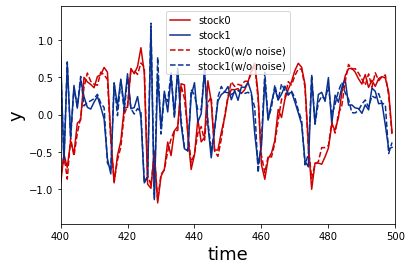

In [3]:
sigma = 0.1
T_total = 500
y, y_without_noise = create_dataset(T_total, sigma)

In [4]:
df_y = pd.DataFrame(y, index=["stock0", "stock1"]).T

df_y.head()

,stock0,stock1
0,0.100000,0.100000
1,0.077916,0.526656
2,0.636092,0.020441
3,0.722505,-0.066153
4,0.397189,-0.750152


# 训练

In [5]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    operators_max, operators_min, operators_add, operators_diff, get_x, get_y,
    operators_multiple, x_is_greater_than_y
]

stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4

model = Company(stock_names,
                num_factors_max,
                delay_time_max,
                activation_funcs,
                binary_operators,
                num_traders=40,
                Q=0.2,
                time_window=time_window,
                how_recruit="random")

In [6]:
T_train = 400
df_y_train = df_y.iloc[:T_train, :]
df_y_test = df_y.iloc[T_train:, :]

In [7]:
model.fit(df_y_train)

100%|██████████| 397/397 [03:38<00:00,  1.81it/s] 


In [8]:
model.aggregate()

array([-0.65802183,  0.49276708])

In [9]:
model.traders[0].X_factors[0]

array([[ 1.73192814e-01,  1.00000000e+00,  5.62716533e-02],
       [ 1.56757680e-01,  1.00000000e+00,  4.72548727e-01],
       [ 5.38000678e-01,  0.00000000e+00,  3.54234457e-01],
       [-4.84710859e-02,  0.00000000e+00,  5.40197575e-01],
       [-3.87297953e-01,  0.00000000e+00,  4.58564042e-02],
       [-7.41185165e-01,  0.00000000e+00, -1.84502017e-01],
       [-1.80919635e-01,  1.00000000e+00,  2.80912126e-01],
       [ 3.84087527e-01,  1.00000000e+00, -1.12092028e+00],
       [-4.40208643e-01,  1.00000000e+00, -8.25963180e-02],
       [ 2.16930563e-01,  1.00000000e+00, -4.79090889e-01],
       [ 2.62582032e-01,  1.00000000e+00, -1.00215554e-01],
       [ 2.45233794e-01,  1.00000000e+00,  1.32931600e-02],
       [ 1.20848180e-01,  1.00000000e+00,  4.74109650e-01],
       [ 3.22592542e-01,  0.00000000e+00,  3.04070590e-01],
       [-1.46731977e-02,  0.00000000e+00,  7.51246061e-01],
       [ 1.39392067e-01,  0.00000000e+00,  3.83467531e-01],
       [-1.76992146e-01,  0.00000000e+00

# 测试

In [10]:
errors_test_notuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_notuning.append(np.abs(row.values - prediction_test))

    # tuning==Falseの場合、データが追加されても重みの更新などパラメータは変わらない
    model.fit_new_data(row.to_dict(), tuning=False)

errors_test_tuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_tuning.append(np.abs(row.values - prediction_test))

    # tuning==Trueの場合、データが追加された際に重みの更新などパラメータが調整される
    model.fit_new_data(row.to_dict(), tuning=True)

0it [00:00, ?it/s]

e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecate

0it [00:00, ?it/s]

e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
e:\WorkSpace\Quantitative-analysis\C-择时类\”Trader-Company“集成算法交易策略\scr\company.py:75: FutureWarning: The frame.append method is deprecate

In [11]:
days_ma = 5

# trader-company errors with no-tuning
errors_test_notuning = np.array(errors_test_notuning)
errors_test_notuning_ma = pd.DataFrame(errors_test_notuning).rolling(
    days_ma).mean()

# trader-company errors with tuning
errors_test_tuning = np.array(errors_test_tuning)
errors_test_tuning_ma = pd.DataFrame(errors_test_tuning).rolling(
    days_ma).mean()

# baseline method
errors_baseline = np.abs(y[:, T_train + 1:] - y[:, T_train:-1])
errors_baseline_ma = pd.DataFrame(errors_baseline.T).rolling(days_ma).mean()

# lower bound
errors_lower_bound = np.abs(y[:, T_train + 1:] -
                            y_without_noise[:, T_train + 1:])
errors_lower_bound_ma = pd.DataFrame(
    errors_lower_bound.T).rolling(days_ma).mean()


stock0


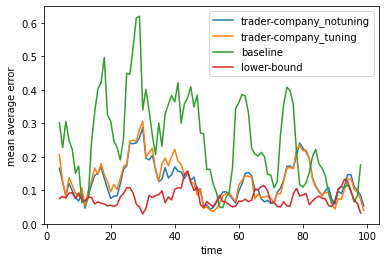

stock1


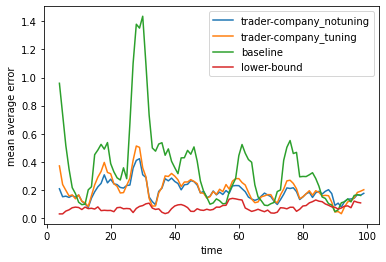

In [12]:
for i_stock, name in enumerate(stock_names):
    print(name)
    plt.plot(errors_test_notuning_ma[i_stock], label="trader-company_notuning")
    plt.plot(errors_test_tuning_ma[i_stock], label="trader-company_tuning")
    plt.plot(errors_baseline_ma[i_stock], label="baseline")
    plt.plot(errors_lower_bound_ma[i_stock], label="lower-bound")
    plt.xlabel("time")
    plt.ylabel("mean average error")
    plt.legend()
    plt.show()